# Практическое задание №5 "Случайный лес".

1. Сформировать с помощью sklearn.make_classification датасет из 100 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). 

2. Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем

3. Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

4. (На повторение) Переписать функцию gini из урока про решающие деревья так, чтобы в качестве критерия использовалась энтропия Шэннона. Переименовать функцию в entropy и сравнить результаты построения леса по Шеннону и Gini.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets, model_selection

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Задание №1

__Методы и классы__

In [3]:
# Реализуем класс узла
class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [4]:
# И класс терминального узла (листа)
class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction   

In [5]:
# Расчет критерия Джини
def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [6]:
# Расчет качества
def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [7]:
# Случайное подмножество признаков
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы, для экономии памяти
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [8]:
# Разбиение датасета в узле
def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [9]:
# Нахождение наилучшего разбиения
def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения 
        # (в дереве решений мы делали обход по всем признакам) 
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [10]:
# Построение дерева с помощью рекурсивной функции
def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [11]:
# Бутстрап
random.seed(42)
def get_bootstrap(data, labels, N):
    # количество деревьев, признаки, метки
    # Сколько деревьев, столько и бутстреп выборок
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [12]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

Предсказание

In [13]:
# Функция классификации отдельного объекта
def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [14]:
# функция формирования предсказания по выборке на одном дереве
def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [15]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Точность

In [16]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

__Генерация датасета, обучение, визуализация__

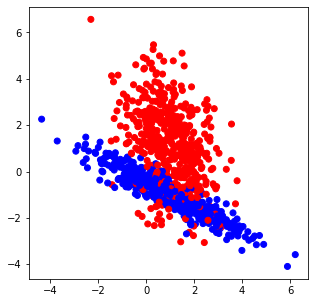

In [17]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(5,5))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [18]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

Обучение лесов с разным количеством деревьев:

In [19]:
#1
n_trees_1 = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees_1)
train_answers_1 = tree_vote(my_forest_1, train_data)
test_answers_1 = tree_vote(my_forest_1, test_data)
train_accuracy_1 = accuracy_metric(train_labels, train_answers_1)
test_accuracy_1 = accuracy_metric(test_labels, test_answers_1)
#2
n_trees_3 = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees_3)
train_answers_3 = tree_vote(my_forest_3, train_data)
test_answers_3 = tree_vote(my_forest_3, test_data)
train_accuracy_3 = accuracy_metric(train_labels, train_answers_3)
test_accuracy_3 = accuracy_metric(test_labels, test_answers_3)
#3
n_trees_10 = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees_10)
train_answers_10 = tree_vote(my_forest_10, train_data)
test_answers_10 = tree_vote(my_forest_10, test_data)
train_accuracy_10 = accuracy_metric(train_labels, train_answers_10)
test_accuracy_10 = accuracy_metric(test_labels, test_answers_10)
#4
n_trees_50 = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees_50)
train_answers_50 = tree_vote(my_forest_50, train_data)
test_answers_50 = tree_vote(my_forest_50, test_data)
train_accuracy_50 = accuracy_metric(train_labels, train_answers_50)
test_accuracy_50 = accuracy_metric(test_labels, test_answers_50)

print(f"Random Forest (n_trees={n_trees_1}), Accuracy: Train={train_accuracy_1} | Test={test_accuracy_1}")
print(f"Random Forest (n_trees={n_trees_3}), Accuracy: Train={train_accuracy_3} | Test={test_accuracy_3}")
print(f"Random Forest (n_trees={n_trees_10}), Accuracy: Train={train_accuracy_10} | Test={test_accuracy_10}")
print(f"Random Forest (n_trees={n_trees_50}), Accuracy: Train={train_accuracy_50} | Test={test_accuracy_50}")

Random Forest (n_trees=1), Accuracy: Train=97.0 | Test=93.0
Random Forest (n_trees=3), Accuracy: Train=98.57142857142858 | Test=95.66666666666667
Random Forest (n_trees=10), Accuracy: Train=99.85714285714286 | Test=96.66666666666667
Random Forest (n_trees=50), Accuracy: Train=100.0 | Test=97.33333333333334


Визуализация

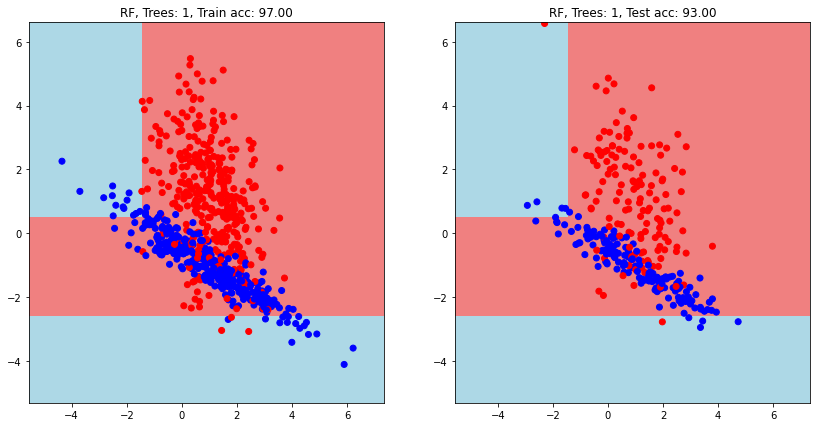

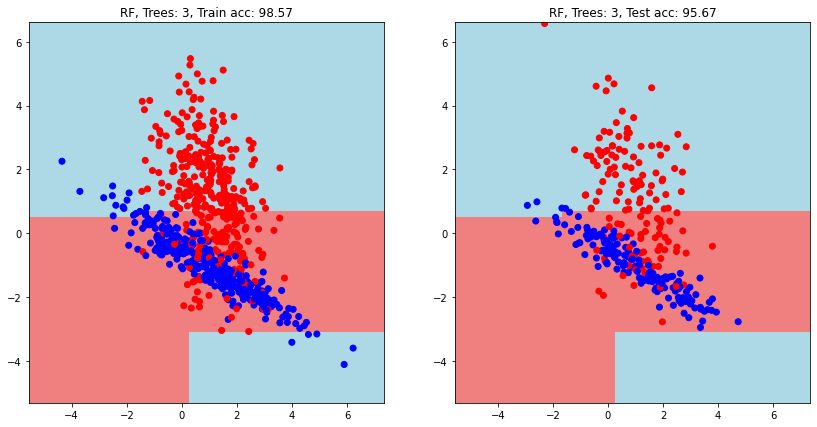

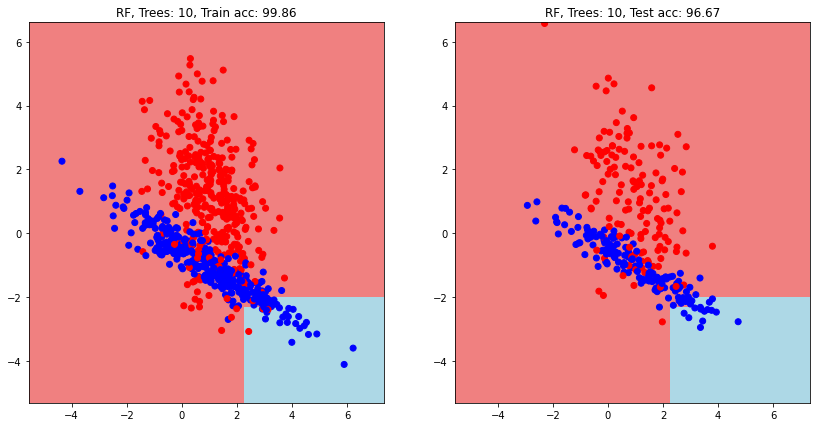

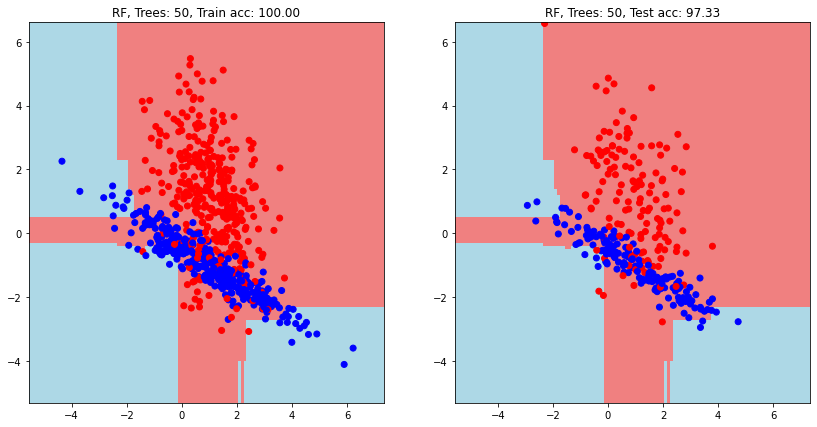

In [20]:
# Визуализируем дерево на графике
def get_meshgrid(data, step=.1, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    xx,yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step)) 
    x = xx.reshape(-1,1)
    y = yy.reshape(-1,1)
    f = np.ones((x.shape[0],data[:, 2:].shape[1]))
#     f = np.zeros((x.shape[0],data[:, 2:].shape[1]))
#     print(f.shape,x.shape,y.shape)
    data_gr = np.concatenate((x,y,f),axis=1)
    return xx,yy , data_gr #список массивов координатных сеток

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

# tree 1
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_1}, Train acc: {train_accuracy_1:.2f}")

plt.subplot(1,2,2)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_1, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_1}, Test acc: {test_accuracy_1:.2f}")
plt.show()

# tree 2
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_3}, Train acc: {train_accuracy_3:.2f}")

plt.subplot(1,2,2)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_3, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_3}, Test acc: {test_accuracy_3:.2f}")
plt.show()

# tree 3
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_10}, Train acc: {train_accuracy_10:.2f}")

plt.subplot(1,2,2)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_10, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_10}, Test acc: {test_accuracy_10:.2f}")
plt.show()

# tree 3
plt.figure(figsize=(14, 7))
plt.subplot(1,2,1)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_50}, Train acc: {train_accuracy_50:.2f}")

plt.subplot(1,2,2)
xx, yy, gr = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest_50, gr)).reshape(xx.shape) # определяем цвета квадратов в сетке
plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap=colors)
plt.title(f"RF, Trees: {n_trees_50}, Test acc: {test_accuracy_50:.2f}")
plt.show()

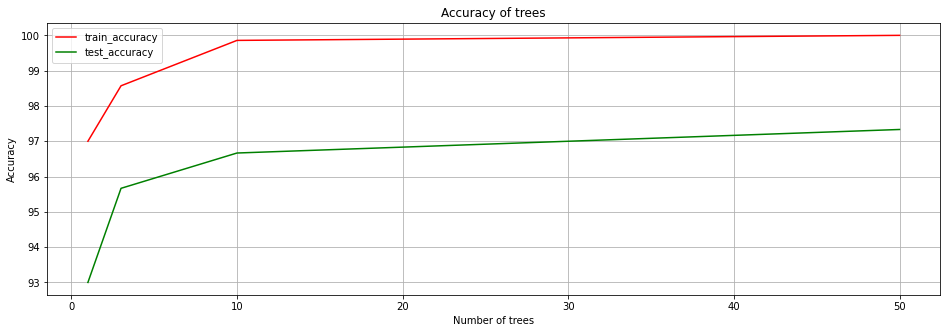

In [21]:
acc_tr = [train_accuracy_1, train_accuracy_3, train_accuracy_10, train_accuracy_50]
acc_tst = [test_accuracy_1, test_accuracy_3, test_accuracy_10, test_accuracy_50]
acc_x = [n_trees_1, n_trees_3, n_trees_10, n_trees_50]

plt.figure(figsize = (16, 5))
plt.plot(acc_x, acc_tr, color='r', label = 'train_accuracy')
plt.plot(acc_x, acc_tst, color='g', label = 'test_accuracy')
plt.title('Accuracy of trees')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

## Задание №2

* C увеличением количества деревьев возрастает сложность гиперплоскости (увеличивается количество граней)

* Как можно увидеть из графика показателя качества предсказаний (Accuracy), точность случайного леса возрастает при увеличении числа деревьев в нём и при увеличении количества деревьев до 50 наш лес не переобучается. 

## Задание №3

Как я понимаю, нужно оценить качество предсказаний с помощью Out-of-bag (OOB) error, а также не нужно делать разбиение датасета на Train и Test.

OOB error рассчитывается как сумма значений ошибки для среднего ответа на каждом объекте $x_{i}$ среди деревьев, которые на нем не обучались:

$$OOB = \sum^{l}_{i=1}L\left ( y_{i}, \:\frac{1}{\sum^{N}_{n=1}[x_{i}\notin X_{n}]} \sum^{N}_{n=1}[x_{i} \notin X_{n}]b_{n}(x_{i}) \right ).$$

На вебинаре узнали, что алгоритм расчета OOB error:

$$OOBE = \sum_{i=1}^{l} \frac{E}{f_{f\neq0}}$$

$l$ - количество объектов в исходной выборке $X$, 

$E$ - вектор ошибок (значение ячейки - количество ошибок i-го объекта, то есть количество раз когда объект попал в тест и модель классифицировала его неверно), 

$f_{f\neq0}$ - количество появлений объекта в тесте каждой модели (дерева), не учитывать объекты, которые не попали в тест. 

__Методы и классы__

In [22]:
# Бутстрап с отдельным сохранением индексов объектов, которые не попали в бутстрап.
random.seed(42)
def get_bootstrap_oobe(data, labels, N):
    # количество деревьев, признаки, метки
    n_samples = data.shape[0]
    bootstrap = []
    # маски
    boorstrap_oobe = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        oobe_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            oobe_labels[sample_index] += 1
        oobe_labels = np.logical_not(oobe_labels).astype(int)
        bootstrap.append((b_data, b_labels))
        boorstrap_oobe.append(oobe_labels)
        
    return bootstrap, boorstrap_oobe

In [23]:
# Подсчет OOB error по формуле выше
def calculate_oobe(oobe_e, oobe_f):
    mask = oobe_f != 0
    oobe_e = oobe_e[mask]
    oobe_f = oobe_f[mask]
    res = np.sum(oobe_e/oobe_f)
    
    return res

In [24]:
# Построение леса, расчет ошибки OOB для леса
def random_forest_oobe(data, labels, n_trees):
    forest = []
    bootstrap, bootstrap_oobe = get_bootstrap_oobe(data, labels, n_trees)
    oobe_e = np.zeros(labels.shape)
    oobe_f = np.sum(bootstrap_oobe, axis=0)
    
    for i in range(len(bootstrap)):
        b_data = bootstrap[i][0]
        b_labels = bootstrap[i][1]
        b_oobe = bootstrap_oobe[i]
        
        tree_i = build_tree(b_data, b_labels)
        forest.append(tree_i)
        
        # посчитаем количество ошибок для одного дерева для каждого объекта
        mask = np.where(b_oobe==1)[0]
        test_data = data[mask]
        pred_i = predict(test_data, tree_i)
        for j in range(len(mask)):
            d_idx = mask[j]
            if labels[d_idx] != pred_i[j]:
                oobe_e[d_idx] += 1
    oobe = calculate_oobe(oobe_e, oobe_f)
    
    return forest, oobe

__Генерация датасета, обучение, расчет ошибки, визуализация__

Датасет:

In [25]:
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 5, n_informative = 5, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)
X = classification_data
y = classification_labels

Обучение лесов с разным количеством деревьев:

In [26]:
#1
n_trees_1 = 1
my_forest_oobe_1, oobe_1 = random_forest_oobe(X, y, n_trees_1)
#2
n_trees_3 = 3
my_forest_oobe_3, oobe_3 = random_forest_oobe(X, y, n_trees_3)
#1
n_trees_10 = 10
my_forest_oobe_10, oobe_10 = random_forest_oobe(X, y, n_trees_10)
#1
n_trees_50 = 50
my_forest_oobe_50, oobe_50 = random_forest_oobe(X, y, n_trees_50)

In [27]:
print(f"Random Forest (n_trees={n_trees_1}), OOB error: {oobe_1}")
print(f"Random Forest (n_trees={n_trees_3}), OOB error: {oobe_3}")
print(f"Random Forest (n_trees={n_trees_10}), OOB error: {oobe_10}")
print(f"Random Forest (n_trees={n_trees_50}), OOB error: {oobe_50}")

Random Forest (n_trees=1), OOB error: 34.0
Random Forest (n_trees=3), OOB error: 62.33333333333333
Random Forest (n_trees=10), OOB error: 81.18333333333334
Random Forest (n_trees=50), OOB error: 85.30522166751784


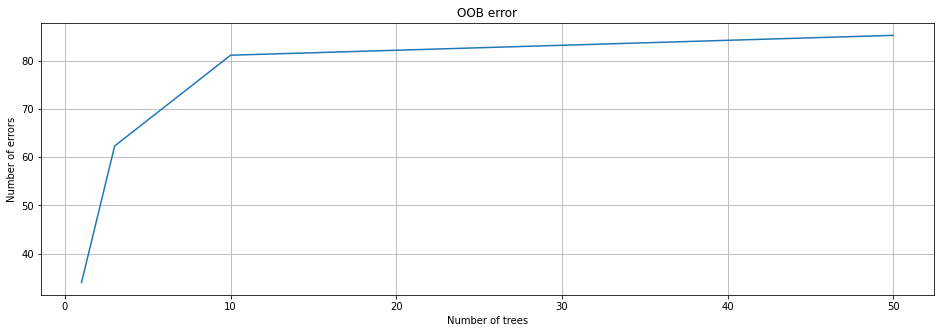

In [28]:
oob_error = [oobe_1, oobe_3, oobe_10, oobe_50]
trees = [n_trees_1, n_trees_3, n_trees_10, n_trees_50]

plt.figure(figsize = (16, 5))
plt.plot(trees, oob_error)
plt.title('OOB error')
plt.xlabel('Number of trees')
plt.ylabel('Number of errors')
plt.grid()

Частота ошибки на одно дерево с увеличением количества деревьев в лесу:

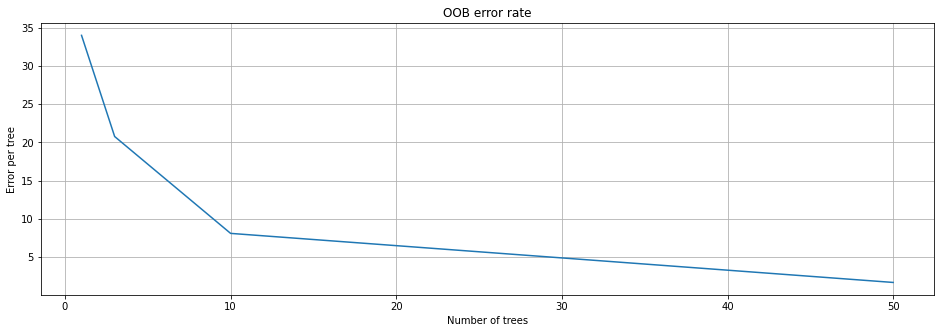

In [29]:
oob_error = [oobe_1/n_trees_1, oobe_3/n_trees_3, oobe_10/n_trees_10, oobe_50/n_trees_50]
trees = [n_trees_1, n_trees_3, n_trees_10, n_trees_50]

plt.figure(figsize = (16, 5))
plt.plot(trees, oob_error)
plt.title('OOB error rate')
plt.xlabel('Number of trees')
plt.ylabel('Error per tree')
plt.grid()

* На первом графике видно, что с увеличением количества деревьев количество ошибок растет с меньшей скоростью.

* Количество ошибок на 1 дерево уменьшается с увеличением количества деревьев

Таким образом, модель улучшается (становится точнее), что соответствует результатам из _задания №1_

## Задание №4

__Методы и классы__

Переопределим методы с учетом нового критерия информативности:

In [30]:
# Расчет критерия Шеннона
def entropy(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    H = 0
    for label in classes:
        p = classes[label]/len(labels)
        H -= 0 if p==0 else p*np.log2(p)
    return H

In [31]:
# Расчет качества
def quality_entropy(left_labels, right_labels, current_entropy):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_entropy - p * entropy(left_labels) - (1 - p) * entropy(right_labels)

In [32]:
# Нахождение наилучшего разбиения
def find_best_split_entropy(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_entropy = entropy(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1] - 1
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения 
        # (в дереве решений мы делали обход по всем признакам) 
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality_entropy(true_labels, false_labels, current_entropy)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [33]:
# Построение дерева с помощью рекурсивной функции
def build_tree_entropy(data, labels):
    quality, t, index = find_best_split_entropy(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_entropy(true_data, true_labels)
    false_branch = build_tree_entropy(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [34]:
def random_forest_entropy(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree_entropy(b_data, b_labels))
        
    return forest

__Обучение, визуализация__

Обучение лесов с разным количеством деревьев:

In [35]:
#1
n_trees_1 = 1
e_my_forest_1 = random_forest_entropy(train_data, train_labels, n_trees_1)
e_train_answers_1 = tree_vote(e_my_forest_1, train_data)
e_test_answers_1 = tree_vote(e_my_forest_1, test_data)
e_train_accuracy_1 = accuracy_metric(train_labels, e_train_answers_1)
e_test_accuracy_1 = accuracy_metric(test_labels, e_test_answers_1)
#2
n_trees_3 = 3
e_my_forest_3 = random_forest_entropy(train_data, train_labels, n_trees_3)
e_train_answers_3 = tree_vote(e_my_forest_3, train_data)
e_test_answers_3 = tree_vote(e_my_forest_3, test_data)
e_train_accuracy_3 = accuracy_metric(train_labels, e_train_answers_3)
e_test_accuracy_3 = accuracy_metric(test_labels, e_test_answers_3)
#3
n_trees_10 = 10
e_my_forest_10 = random_forest_entropy(train_data, train_labels, n_trees_10)
e_train_answers_10 = tree_vote(e_my_forest_10, train_data)
e_test_answers_10 = tree_vote(e_my_forest_10, test_data)
e_train_accuracy_10 = accuracy_metric(train_labels, e_train_answers_10)
e_test_accuracy_10 = accuracy_metric(test_labels, e_test_answers_10)
#4
n_trees_50 = 50
e_my_forest_50 = random_forest_entropy(train_data, train_labels, n_trees_50)
e_train_answers_50 = tree_vote(e_my_forest_50, train_data)
e_test_answers_50 = tree_vote(e_my_forest_50, test_data)
e_train_accuracy_50 = accuracy_metric(train_labels, e_train_answers_50)
e_test_accuracy_50 = accuracy_metric(test_labels, e_test_answers_50)

print(f"Random Forest (n_trees={n_trees_1}), Accuracy: Train={e_train_accuracy_1} | Test={e_test_accuracy_1}")
print(f"Random Forest (n_trees={n_trees_3}), Accuracy: Train={e_train_accuracy_3} | Test={e_test_accuracy_3}")
print(f"Random Forest (n_trees={n_trees_10}), Accuracy: Train={e_train_accuracy_10} | Test={e_test_accuracy_10}")
print(f"Random Forest (n_trees={n_trees_50}), Accuracy: Train={e_train_accuracy_50} | Test={e_test_accuracy_50}")

Random Forest (n_trees=1), Accuracy: Train=97.28571428571429 | Test=91.0
Random Forest (n_trees=3), Accuracy: Train=98.57142857142858 | Test=95.0
Random Forest (n_trees=10), Accuracy: Train=99.71428571428571 | Test=96.33333333333334
Random Forest (n_trees=50), Accuracy: Train=100.0 | Test=97.33333333333334


__Сравнение построения леса по Шеннону и Gini__

In [36]:
trees = [n_trees_1, n_trees_3, n_trees_10, n_trees_50]
acc_tr_gini = [train_accuracy_1, train_accuracy_3, train_accuracy_10, train_accuracy_50]
acc_tr_entropy = [e_train_accuracy_1, e_train_accuracy_3, e_train_accuracy_10, e_train_accuracy_50]
acc_test_gini = [test_accuracy_1, test_accuracy_3, test_accuracy_10, test_accuracy_50]
acc_test_entropy = [e_test_accuracy_1, e_test_accuracy_3, e_test_accuracy_10, e_test_accuracy_50]

In [37]:
acc_tr_gini, acc_tr_entropy

([97.0, 98.57142857142858, 99.85714285714286, 100.0],
 [97.28571428571429, 98.57142857142858, 99.71428571428571, 100.0])

In [38]:
acc_test_gini, acc_test_entropy

([93.0, 95.66666666666667, 96.66666666666667, 97.33333333333334],
 [91.0, 95.0, 96.33333333333334, 97.33333333333334])

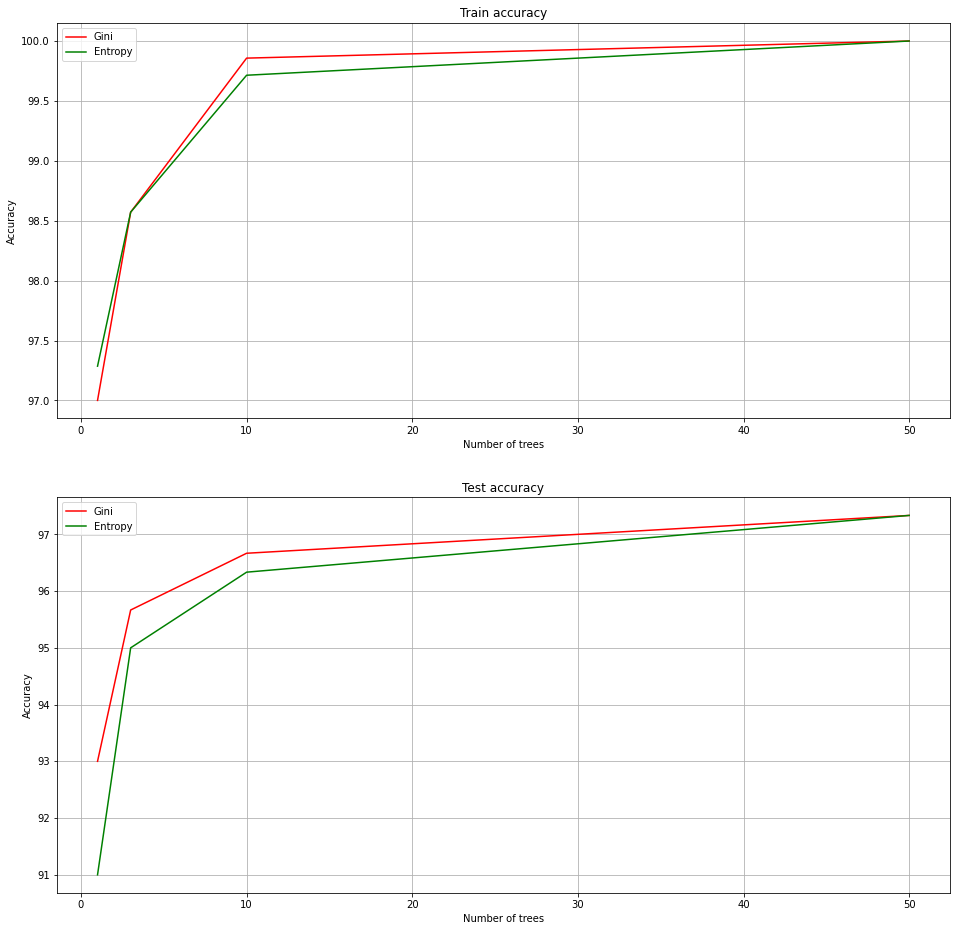

In [39]:
plt.figure(figsize = (16, 16))
plt.subplot(2,1,1)
plt.plot(trees, acc_tr_gini, color='r', label = 'Gini')
plt.plot(trees, acc_tr_entropy, color='g', label = 'Entropy')
plt.title('Train accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
plt.plot(trees, acc_test_gini, color='r', label = 'Gini')
plt.plot(trees, acc_test_entropy, color='g', label = 'Entropy')
plt.title('Test accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

На тестовой выборке как мы видим точность по критерию Шеннона растет медленее, но в определенный момент (с увеличением количества деревьев) сравнивается с точностью по критерию Джини.

---